In [ ]:
! pip install transformers

     |████████████████████████████████| 3.4 MB 10.9 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 61 kB 537 kB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
! pip install torch

In [ ]:
! pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 11.0 MB/s 
     |████████████████████████████████| 131 kB 45.2 MB/s 
     |████████████████████████████████| 8.4 MB 45.5 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 138 kB 32.9 MB/s 
     |████████████████████████████████| 127 kB 50.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

import gensim
import re
import html
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertForSequenceClassification
from transformers import AdamW, BertTokenizerFast, get_linear_schedule_with_warmup
import torch.nn.functional as nnf


# Specifing GPU
device = torch.device("cuda")
print(device)

cuda


In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#DATA

df_train = pd.read_csv("/content/data/train.csv")
df_test = pd.read_csv("/content/data/test.csv")
df_labels = pd.read_csv("/content/data/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

# Shuffling data
df = df.sample(frac=1)
# Dropping duplicates & NaN rows
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(subset = ["text"], inplace=True)
df.dropna(subset = ["title"], inplace=True)

In [ ]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
# Removing HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
# Removing all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
# Removing URLs
    clean = re.sub('\W+',' ', clean)                   
# Replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [ ]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [ ]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])


889      wallonia cave belgium reach secret canada trad...
12540    terry branstad iowa governor trump pick china ...
12853    thing watch trump israel trip jerusalem monday...
1294     season end begin baseball playoff matchup york...
24698    donald trump big fan hindu nationalist york ti...
                               ...                        
17974    biden hint response russia cyberattacks york t...
24101    california massachusetts legalize recreational...
4188     resist democrat turn idea conference republica...
25405    russian expert expect donald trump november fo...
22067    trump appoint religious liberty defender roger...
Name: clean_joined, Length: 24802, dtype: object


In [ ]:
#BUILDING AND TRAINING PRETRAINED MODEL

# Loading BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Using the 12-layer BERT model, with an uncased vocabulary
    num_labels = 2, # The number of output labels - 2 for binary classification
              
)

# Pushing the model to GPU
model = model.to(device)

100%|██████████| 407873900/407873900 [00:13<00:00, 29444874.17B/s]


In [ ]:
# Loading the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Splitting train dataset into train, validation and test sets and dropping NaN before that
df = df.dropna()
x_train, x_test, y_train, y_test = train_test_split(df['clean_joined'], df['label'], random_state=2018, test_size=0.2, stratify=df['label'])

x_train, x_temp, y_train, y_temp = train_test_split(df['clean_joined'], df['label'], random_state=2018, test_size=0.3, stratify=df['label'])

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, random_state=2018, test_size=0.7, stratify=y_temp)

In [82]:
# Tokenizing and encoding sequences
tokens_train = tokenizer.batch_encode_plus( x_train.tolist(), max_length = 100, pad_to_max_length=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus( x_val.tolist(), max_length = 100, pad_to_max_length=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus( x_test.tolist(), max_length = 100, pad_to_max_length=True, truncation=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [83]:
# Converting lists to tensors

train_tokens_tensor = torch.tensor(tokens_train['input_ids'])
train_masks_tensor = torch.tensor(tokens_train['attention_mask'])
train_y_tensor = torch.tensor(y_train.tolist())

val_tokens_tensor = torch.tensor(tokens_val['input_ids'])
val_masks_tensor = torch.tensor(tokens_val['attention_mask'])
val_y_tensor = torch.tensor(y_val.tolist())

test_tokens_tensor = torch.tensor(tokens_test['input_ids'])
test_masks_tensor = torch.tensor(tokens_test['attention_mask'])
test_y_tensor = torch.tensor(y_test.tolist())

# Prepairing dataloaders
batch_size = 16

train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_tokens_tensor, val_masks_tensor, val_y_tensor)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = RandomSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)


In [84]:
# Computing the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)

# Converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# Pushing weights to GPU
weights = weights.to(device)

# Defining the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                )

In [ ]:
# Training the model
def train():
  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  # Model predictions
  total_preds=[]

  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Pushing the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # Clearing previously calculated gradients 
    model.zero_grad()        

    # Getting model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Adding on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clipping the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Updating parameters
    optimizer.step()

    # Pushing model predictions to CPU
    preds=preds.detach().cpu().numpy()

    # Appending the model predictions
    total_preds.append(preds)

  # Computing the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# Validating the model
def evaluate():
  
  print("\nEvaluating...")
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # Model predictions
  total_preds = []

  # Iterating over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches
    if step % 100 == 0 and not step == 0:
            
      # Reporting progress
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Pushing the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # Deactivating autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Computing the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Computing the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [85]:
#FINE-TUNING THE MODEL

# Number of training epochs
epochs = 2

# Setting initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Training model
    train_loss, _ = train()
    
    # Evaluating model
    valid_loss, _ = evaluate()
    
    # Appending training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print("  Average training loss: {0:.2f}".format(train_loss))
    print("  Average training loss: {0:.2f}".format(valid_loss))


 Epoch 1 / 2
  Batch   100  of  1,086.
  Batch   200  of  1,086.
  Batch   300  of  1,086.
  Batch   400  of  1,086.
  Batch   500  of  1,086.
  Batch   600  of  1,086.
  Batch   700  of  1,086.
  Batch   800  of  1,086.
  Batch   900  of  1,086.
  Batch 1,000  of  1,086.

Evaluating...
  Batch   100  of    140.
  Average training loss: -53.28
  Average training loss: -61.04

 Epoch 2 / 2
  Batch   100  of  1,086.
  Batch   200  of  1,086.
  Batch   300  of  1,086.
  Batch   400  of  1,086.
  Batch   500  of  1,086.
  Batch   600  of  1,086.
  Batch   700  of  1,086.
  Batch   800  of  1,086.
  Batch   900  of  1,086.
  Batch 1,000  of  1,086.

Evaluating...
  Batch   100  of    140.
  Average training loss: -68.91
  Average training loss: -76.65


In [101]:
#TESTING THE MODEL

model.eval()

predictions , true_labels, pred_probas = [], [], []

# Iterating over batches
for step,batch in enumerate(test_dataloader):

  # Pushing the batches to gpu
  batch = [t.to(device) for t in batch]
  input_ids, mask, labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate output predictions
      outputs = model(input_ids, attention_mask=mask)
      # Probabilities for predictions
      proba = nnf.softmax(outputs, dim=1)

  # Moving logits and labels to CPU
  outputs = outputs.detach().cpu().numpy()
  logits = np.argmax(outputs, axis=1).flatten()
  label_ids = labels.to('cpu').numpy()
  probas = proba.detach().cpu().numpy()

  
  # Storing predictions, true labels, and probabilities
  predictions.append(logits)
  true_labels.append(label_ids)
  pred_probas.append(probas)


DONE.


In [107]:
# Extracting values from batches

true_labels_list = []
predictions_list = []
probas_list = []
for i in range(len(true_labels)):
  for j in range(len(true_labels[i])):
    true_labels_list.append(true_labels[i][j])
    predictions_list.append(predictions[i][j])
    probas_list.append(pred_probas[i][j])
  i += 1  

Model accuracy is :  0.8930696870800537
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2668
           1       0.88      0.90      0.89      2541

    accuracy                           0.89      5209
   macro avg       0.89      0.89      0.89      5209
weighted avg       0.89      0.89      0.89      5209



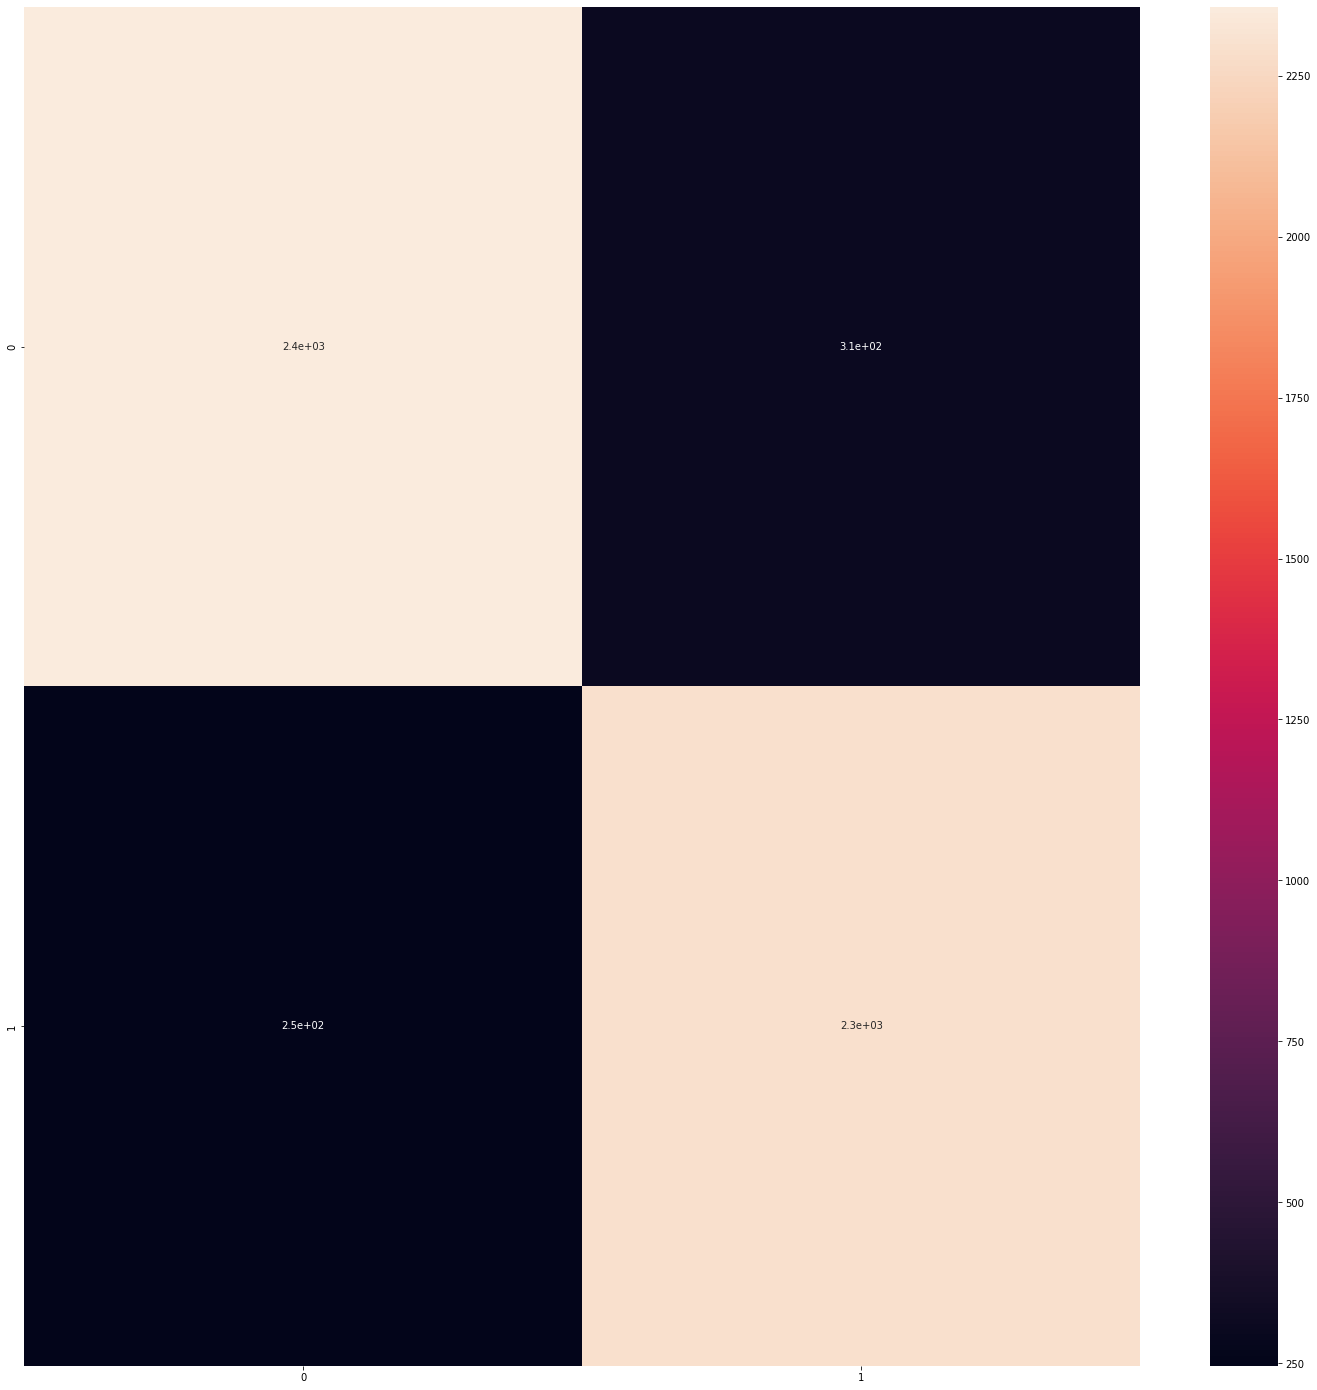

In [89]:
# EVALUATION OF THE BERT MODEL

preds = []
# If the prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(predictions_list)):
    if predictions_list[i].item() > 0.5:
        preds.append(1)
    else:
        preds.append(0)

# Getting accuracy
accuracy = accuracy_score(true_labels_list, predictions_list)
print("Model accuracy is : ", accuracy)
print(classification_report(true_labels_list, predictions_list))

# Confusion matrix
c_matrix = confusion_matrix(true_labels_list, predictions_list)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
BER: ROC AUC=0.916


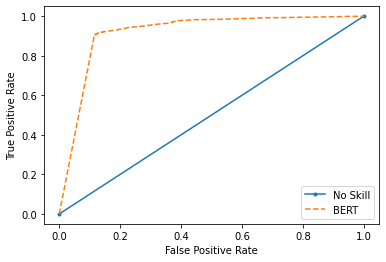

In [115]:
#ROC-CURVE

import matplotlib.pyplot as pyplot
# Generetong a no skill prediction
ns_probs = [0 for _ in range(len(y_test))]


# Keeping probabilities for the positive outcome only
probas_list = np.array(probas_list)[:,1]

# Calculating scores
ns_auc = roc_auc_score(true_labels_list, ns_probs)
lr_auc = roc_auc_score(true_labels_list, probas_list)

# Summarizing scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('BER: ROC AUC=%.3f' % (lr_auc))

# Calculating ROC curves
ns_fpr, ns_tpr, _ = roc_curve(true_labels_list, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(true_labels_list, probas_list)

# Plotting ROC curves
pyplot.plot(ns_fpr, ns_tpr, marker='.', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, linestyle='--', label='BERT')

#Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Showing the legend
pyplot.legend()

#Showing the plot
pyplot.show()